In [2]:
%matplotlib inline
import IPython.core.display         
IPython.core.display.set_matplotlib_formats("svg")

import matplotlib
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn import *

import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 

import numpy as np
import pandas as pd
import string  
import re
import json
from joblib import dump, load

In [3]:
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')
nltk.download('snowball_data')
nltk.download('omw')
nltk.download('stopwords')
nltk.download('popular')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/maloferriol/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maloferriol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maloferriol/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/maloferriol/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/maloferriol/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package snowball_data to
[nltk_data]     /Users/maloferriol/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package omw to /U

True

In [4]:
def confusionMatrix(confm, confmnorm, title, normtitle):
    classNames = ['positive', 'neutral','negative'] 
    ylabel = 'True label'
    xlabel = 'Predicted label'

    plt.subplot(1,2,1)
    plt.imshow(confm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    tick_marks = np.arange(len(classNames))

    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    
    for i in range(len(classNames)):
        for j in range(len(classNames)):
            plt.text(j-0.25,i, str(confm[i][j]))
    plt.subplots_adjust(bottom=0, right=1, top=0.8)

    plt.subplot(1,2,2)

    plt.imshow(confmnorm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(normtitle)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    for i in range(len(classNames)):
        for j in range(len(classNames)):
            plt.text(j-0.25,i, str(confmnorm[i][j]))

    plt.subplots_adjust(bottom=0.1, right=1.6, top=0.9)
    plt.savefig("figure_{}.png".format(title), bbox_inches='tight')
    plt.show()

In [5]:
def preprocessing(sentences):
    lemmatizer = WordNetLemmatizer() 
    
    words = []
     # regex expression to extract URL
    for sent in sentences:
        result = re.sub(r"http\S+", "", sent)
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", result)
        
        token = word_tokenize(clean)
        tokens = ''
        for t in token:
            if (    (t not in stopwords.words('english')) # remove stop words
                and (t not in string.punctuation) # remove punctuation
                and (re.match(r"\b[a-zA-Z]{3,}\b",t)) # keep only the words with more than three character 
                and (re.match(r"(?u)\b\w\w+\b",t)) # regex expression from scikit tokeniser
                    ): 
                tokens += ' ' + lemmatizer.lemmatize(t.lower())
        words.append(tokens)
      
    return words

In [6]:
def catnames_to_number(dataset):
    new_dataset = []
    for cat in dataset:
        if (cat == "positive"):
            new_dataset.append(0)
        elif (cat == "neutral"):
            new_dataset.append(1)
        elif (cat == "negative"):
            new_dataset.append(2)
        else :
            print("error in catnames_to_number")
    return new_dataset

In [7]:
def catnames_to_number_in_row(row):
    new_sent_value = -1
    if (row.sentiment == "positive"):
        new_sent_value = 0
    elif (row.sentiment == "neutral"):
        new_sent_value = 1
    elif (row.sentiment == "negative"):
        new_sent_value = 2
    else :
        print("error in catnames_to_number_in_row")
    return new_sent_value

In [8]:
classNames = ['positive', 'neutral','negative'] 

In [9]:
cntvect = feature_extraction.text.CountVectorizer( 
    input='content',
    encoding="utf-8",
    decode_error="strict", 
    strip_accents="unicode",
    lowercase=True, 
    analyzer='word',
    stop_words="english"
)

tf_transformer = feature_extraction.text.TfidfTransformer()

In [10]:
parameters = {
    'vect__max_features': (1000,2500, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),

    'tfidf__norm': ('l1','l2'),
    'tfidf__use_idf': (False,True),

    'clf__C': np.geomspace(1e-2, 1e1, num=10),
    'clf__solver': ['newton-cg','lbfgs', 'liblinear']
}

In [11]:
pipe = pipeline.Pipeline([
    ('vect', cntvect),
    ('tfidf', tf_transformer),
    ('clf', linear_model.LogisticRegression())
])

gs = model_selection.GridSearchCV(pipe, parameters, cv = 5, n_jobs=-1,verbose=0)

# Import Datasets

### Import Test Dataset

In [12]:
test_samples = pd.read_csv("./datasets/original/test.csv")
test_samples = test_samples.set_index('textID')
test_samples["sentiment"] = test_samples.apply(catnames_to_number_in_row, axis=1)

test_X = test_samples["text"]
test_Y = test_samples["sentiment"]

print(test_X[:10])
print(test_Y[:10])

textID
f87dea47db    Last session of the day  http://twitpic.com/67ezh
96d74cb729     Shanghai is also really exciting (precisely -...
eee518ae67    Recession hit Veronique Branquinho, she has to...
01082688c6                                          happy bday!
33987a8ee5               http://twitpic.com/4w75p - I like it!!
726e501993                      that`s great!! weee!! visitors!
261932614e              I THINK EVERYONE HATES ME ON HERE   lol
afa11da83f     soooooo wish i could, but im in school and my...
e64208b4ef     and within a short time of the last clue all ...
37bcad24ca     What did you get?  My day is alright.. haven`...
Name: text, dtype: object
textID
f87dea47db    1
96d74cb729    0
eee518ae67    2
01082688c6    0
33987a8ee5    0
726e501993    0
261932614e    2
afa11da83f    2
e64208b4ef    1
37bcad24ca    1
Name: sentiment, dtype: int64


### Import Ground Truth Dataset

In [13]:
df_gt = pd.read_csv("./datasets/original/dataset.csv")
df_gt = df_gt.set_index('textID')
df_gt["sentiment"] = df_gt.apply(catnames_to_number_in_row, axis=1)

### Import New Dataset

In [14]:
new_df = pd.read_csv("./datasets/project_dataset/dataset.csv", sep=';')
new_df = new_df.set_index('textID')

# ML Model on Ground Truth

In [15]:
train_gt_X = df_gt["text"]
train_gt_Y = df_gt["sentiment"]

In [16]:
train_gt_X_lem = preprocessing(train_gt_X)

In [17]:
gs.fit(train_gt_X_lem, train_gt_Y); 

lp_pipe_model_gt = gs.best_estimator_

filename_lr_model_gt = 'models/lr_model_gt.joblib'
dump(lp_pipe_model_gt, filename_lr_model_gt) 

['models/lr_model_gt.joblib']

In [18]:
y_gt_pred = lp_pipe_model_gt.predict(train_gt_X_lem)

In [19]:
print(classification_report(train_gt_Y, y_gt_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1716
           1       0.74      0.85      0.79      2224
           2       0.85      0.71      0.77      1556

    accuracy                           0.80      5496
   macro avg       0.81      0.79      0.79      5496
weighted avg       0.80      0.80      0.80      5496



In [20]:
y_gt_test_pred = lp_pipe_model_gt.predict(test_X)

In [21]:
print(classification_report(test_Y, y_gt_test_pred,target_names=classNames))

              precision    recall  f1-score   support

    positive       0.77      0.67      0.72      1103
     neutral       0.58      0.72      0.65      1430
    negative       0.65      0.53      0.58      1001

    accuracy                           0.65      3534
   macro avg       0.67      0.64      0.65      3534
weighted avg       0.66      0.65      0.65      3534



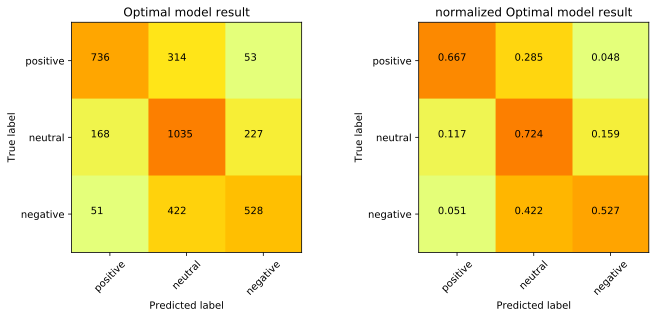

In [22]:
confm = confusion_matrix(test_Y, y_gt_test_pred)
confmnorm = confusion_matrix(test_Y, y_gt_test_pred,normalize='true').round(3)
confusionMatrix(confm, confmnorm, "Optimal model result", "normalized Optimal model result")

# ML Model on New Dataset

In [23]:
new_train_X = new_df["text"]
new_train_Y = new_df["sentiment"]

In [24]:
new_trainX_lem = preprocessing( new_train_X )

In [25]:
gs.fit(new_trainX_lem, new_train_Y); 

new_lr_pipe_model = gs.best_estimator_

new_filename_lr_model = 'models/new_lr_model.joblib'
dump(new_lr_pipe_model, new_filename_lr_model) 

['models/new_lr_model.joblib']

In [26]:
y_new_pred = new_lr_pipe_model.predict(train_gt_X_lem)

In [27]:
print(classification_report(train_gt_Y, y_new_pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      1716
           1       0.65      0.70      0.67      2224
           2       0.75      0.54      0.63      1556

    accuracy                           0.68      5496
   macro avg       0.70      0.68      0.68      5496
weighted avg       0.69      0.68      0.68      5496



In [28]:
y_new_test_pred = new_lr_pipe_model.predict(test_X)

In [29]:
print( classification_report(test_Y, y_new_test_pred,target_names=classNames) )

              precision    recall  f1-score   support

    positive       0.66      0.72      0.69      1103
     neutral       0.59      0.69      0.64      1430
    negative       0.68      0.46      0.55      1001

    accuracy                           0.63      3534
   macro avg       0.65      0.62      0.63      3534
weighted avg       0.64      0.63      0.63      3534



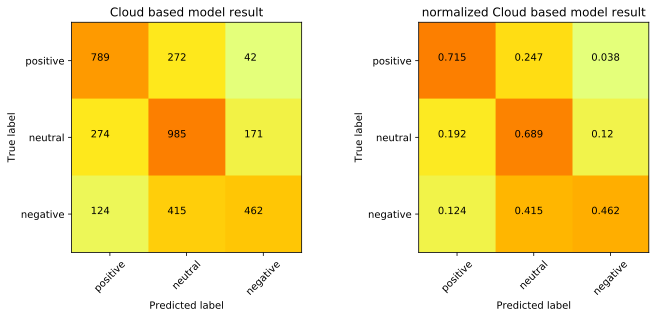

In [30]:
confm = confusion_matrix(test_Y, y_new_test_pred)
confmnorm = confusion_matrix(test_Y, y_new_test_pred,normalize='true').round(3)
confusionMatrix(confm, confmnorm, "Cloud based model result", "normalized Cloud based model result")

# Unsupervised Model

In [31]:
def predict_sentiment(row):
    try:
        article = nltk.word_tokenize(row.text)
    except:
        print("Unexpected error:", row)
        raise 
    
    tagged_text = nltk.pos_tag(article)
    pos_score = neg_score = token_count = obj_score = 0
    
    for word, tag in tagged_text:
        wn_tag = penn_to_wn(tag)
        word = word.lower()
        
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
                continue

        ss_set = list(swn.senti_synsets(word))
        if len(ss_set) == 0:
            continue
        
        ss_set = ss_set[0]

        pos_score += ss_set.pos_score()
        neg_score += ss_set.neg_score()
        obj_score += ss_set.obj_score()
        token_count += 1
        
    o,p,n,f,s = return_object(token_count, obj_score, pos_score, neg_score)
    return o,p,n,f,s

In [32]:
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [33]:
def return_object(token_count, obj_score, pos_score, neg_score):
    pred_sent = 1
    # aggregate final scores
    
    if(token_count==0):
        norm_final_score = norm_obj_score = norm_pos_score = norm_neg_score = 0
    else:
        final_score = pos_score - neg_score
        norm_final_score = round(float(final_score) / token_count, 2)
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        
        if (norm_final_score > 0.1):
            pred_sent = 0
        elif ( -norm_final_score > 0.1):
            pred_sent = 2
    return norm_obj_score, norm_pos_score, norm_neg_score, norm_final_score, pred_sent

In [34]:
df = test_samples
df[["norm_obj_score",
   "norm_pos_score",
   "norm_neg_score",
   "norm_final_score",
   "pred_sent"]] = df.apply(lambda x: predict_sentiment(x), 
                                      axis='columns', 
                                      result_type='expand')

In [35]:
y_us_test_pred = df["pred_sent"]

In [36]:
print( classification_report(test_Y, y_us_test_pred,target_names=classNames ) )

              precision    recall  f1-score   support

    positive       0.63      0.36      0.46      1103
     neutral       0.45      0.84      0.58      1430
    negative       0.68      0.14      0.24      1001

    accuracy                           0.49      3534
   macro avg       0.59      0.45      0.43      3534
weighted avg       0.57      0.49      0.45      3534



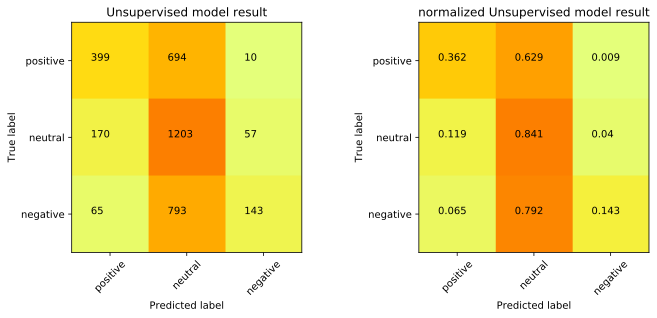

In [37]:
confm = confusion_matrix(test_Y, y_us_test_pred)
confmnorm = confusion_matrix(test_Y, y_us_test_pred,normalize='true').round(3)
confusionMatrix(confm, confmnorm, "Unsupervised model result", "normalized Unsupervised model result")